# Preprocessing Data



In [33]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from collections import Counter
import rfpimp
from sklearn import feature_selection
from sklearn.model_selection import (
                    train_test_split,
                    StratifiedKFold
                                    )
from sklearn import (
                    ensemble,
                    preprocessing,
                    tree,
                    impute,
                    linear_model
                    )

import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer

from sklearn.ensemble import RandomForestClassifier

from yellowbrick.features import RFECV

from sklearn.feature_selection import RFE

from sklearn.utils import resample

In [2]:
# URL to the dataset
url = r"data/titanic.csv"

# Read the dataset
titanic_df = pd.read_csv(url)


orig_df = titanic_df

In [3]:
def clean_titanic(titanic_df: pd.DataFrame):
    """
        Perform cleaning on the Titanic dataset
    """    
    # Create a new copy of the Dataset without altering the orginal df 
    df = titanic_df.copy(deep=True)    
    # Drop irrelevant columns
    df = (
            df.drop(
                    columns=['body',
                             'cabin',
                             'boat',
                             'home.dest',
                             'name',
                             'ticket']  
                    )
             )
    
    # Convert the embarked column to categorical data
    df['embarked'] = (
                      df['embarked']
                      # Convert to categorical type
                      .astype('category')
                     )
    # Convert the sex column to categorical data
    df['sex'] = (
                df['sex']
                # Set as category
                .astype('category')
                )
    # Now lets create dummy columns for the categorical data and avoid Perfoect Colinearity
    df = pd.get_dummies(df, columns=['embarked', 'sex'], drop_first=True) 
    
    return df



In [4]:
def get_train_test_X_y(clean_titanic_df: pd.DataFrame, y_col: str, size: float = 0.3):
    # Get a copy of the original df
    df = clean_titanic_df.copy(deep=True)
    # Get the target
    y = df[y_col]
    # Get the features
    X = df.drop(columns=y_col)
    # Split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)
    # Get all feature cols
    feature_cols = X.columns
    # Get all Numeric columns
    num_cols = [
            'pclass',
            'age',
            'sibsp',
            'parch',
            'fare'
        ]

    cat_cols = [
                'embarked_Q',
                'embarked_S',
                'sex_male'
                ]

    # Impute the missing values based on characteristics of the numeric columns
    imputer = impute.IterativeImputer()

    X_train.loc[:, feature_cols] = imputer.fit_transform(X_train[feature_cols])

    X_test.loc[:, feature_cols] = imputer.transform(X_test[feature_cols])
    
    # Standardising the numeric columns
    scaler = preprocessing.StandardScaler()

    # Standardize the Numeric Features leaving out the Categorical features
    X_train.loc[:, num_cols] = scaler.fit_transform(X_train[num_cols])


    # Standardising the test data
    X_test.loc[:, num_cols] = scaler.transform(X_test[num_cols])
    
    return X_train, X_test, y_train, y_test


#Cleaning Data
clean_df = clean_titanic(titanic_df=orig_df)


# Get the testing and training set
X_train, X_test, y_train, y_test = get_train_test_X_y(clean_titanic_df=clean_df, y_col='survived')


# Concatenate all the data
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)



In [5]:
X_2 = pd.DataFrame(
    {
        "a": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        "b": [-12000, -11000, 0, 1000, 2000, 3000, 4000, 5000, 6000, 7000],
    }
)

X_2

,a,b
0,1,-12000
1,2,-11000
2,3,0
3,4,1000
4,5,2000
5,6,3000
6,7,4000
7,8,5000
8,9,6000
9,10,7000


> Some algorithms, such as SVM, perform better when the data is
standardized. Each column should have a mean value of 0 and standard
deviation of 1.

In [6]:
# Performing Standardisation

std = preprocessing.StandardScaler()

std.fit_transform(X_2)


array([[-1.5666989 , -1.97027602],
       [-1.21854359, -1.81265393],
       [-0.87038828, -0.07881104],
       [-0.52223297,  0.07881104],
       [-0.17407766,  0.23643312],
       [ 0.17407766,  0.3940552 ],
       [ 0.52223297,  0.55167728],
       [ 0.87038828,  0.70929937],
       [ 1.21854359,  0.86692145],
       [ 1.5666989 ,  1.02454353]])

In [7]:
std.scale_

array([2.87228132e+00, 6.34428877e+03])

In [8]:
# Original Mean
std.mean_

array([  5.5, 500. ])

In [9]:
# Original Std Dev
std.var_

array([8.250e+00, 4.025e+07])

> Remember that you will need to track the original
mean and standard deviation if you use this for preprocessing. Any sample
that you will use to predict later will need to be standardized with those
same values. This is to prevent DATA LEAKAGE.

In [10]:
X_std = (X_2 - X_2.mean()) / X_2.std()

X_std

,a,b
0,-1.486301,-1.869168
1,-1.156012,-1.719635
2,-0.825723,-0.074767
3,-0.495434,0.074767
4,-0.165145,0.224300
5,0.165145,0.373834
6,0.495434,0.523367
7,0.825723,0.672900
8,1.156012,0.822434
9,1.486301,0.971967


## Scale to Range

Scaling to range is translating data so it is between 0 and 1, inclusive.
Having the data bounded may be useful. However, if you have outliers, you
probably want to be careful using this

In [11]:
mms = preprocessing.MinMaxScaler()

mms.fit(X_2)

mms.transform(X_2)

array([[0.        , 0.        ],
       [0.11111111, 0.05263158],
       [0.22222222, 0.63157895],
       [0.33333333, 0.68421053],
       [0.44444444, 0.73684211],
       [0.55555556, 0.78947368],
       [0.66666667, 0.84210526],
       [0.77777778, 0.89473684],
       [0.88888889, 0.94736842],
       [1.        , 1.        ]])

## Dummy Variables

We can use pandas to create dummy variables from categorical data. This is
also referred to as one-hot encoding, or indicator encoding. Dummy
variables are especially useful if the data is nominal (unordered). The
get_dummies function in pandas creates multiple columns for a categorical
column, each with a 1 or 0 if the original column had that value:

In [12]:
X_cat = pd.DataFrame({
    'name': ['Maame', 'Marvin', 'David'],
    'inst': ['drums', 'guitar', 'piano']
})


X_cat

,name,inst
0,Maame,drums
1,Marvin,guitar
2,David,piano


In [13]:
pd.get_dummies(X_cat, drop_first=True)

,name_Maame,name_Marvin,inst_guitar,inst_piano
0,1,0,0,0
1,0,1,1,0
2,0,0,0,1


## Label Encoder

An alternative to dummy variable encoding is label encoding. This will take
categorical data and assign each value a number. It is useful for high cardinality data. This encoder imposes ordinality, which may or may not be desired. It can take up less space than one-hot encoding, and some (tree) algorithms can deal with this encoding.

In [14]:
lab = preprocessing.LabelEncoder()

lab.fit_transform(X_cat['inst'])

array([0, 1, 2])

In [15]:
# Inverse transform

lab.inverse_transform([0,1,2])

array(['drums', 'guitar', 'piano'], dtype=object)

## Frequency Encoding

Another option for handling high cardinality categorical data is to frequency
encode it. This means replacing the name of the category with the count it
had in the training data. We will use pandas to do this. First, we will use the
pandas .value_counts method to make a mapping (a pandas series that
maps strings to counts). With the mapping we can use the .map method to
do the encoding:

In [16]:
X_cat = pd.DataFrame({
    'name': ['Maame', 'Marvin', 'Maame', 'Marvin', 'David'],
    'inst': ['drums', 'guitar', 'piano', 'piano', 'drums']
})

mapping = X_cat.name.value_counts()

X_cat.name.map(mapping)

0    2
1    2
2    2
3    2
4    1
Name: name, dtype: int64

> Make sure you store the training mapping so you can encode future data
with the same data.

In [17]:
mapping

Maame     2
Marvin    2
David     1
Name: name, dtype: int64

## Pulling Categories from Strings

One way to increase the accuracy of the Titanic model is to pull out titles
from the names. A quick hack to find the most common triples is to use the
Counter class:

In [18]:



c = Counter()

def triples(val):
    for i in range(len(val)):
        c[val[i : i + 3]] += 1
        

titanic_df['name'].apply(triples)

c.most_common(10)

[(', M', 1282),
 (' Mr', 954),
 ('r. ', 830),
 ('Mr.', 757),
 ('s. ', 460),
 ('n, ', 320),
 (' Mi', 283),
 ('iss', 261),
 ('ss.', 261),
 ('Mis', 260)]

> Another option is to use a regular expression to pull out the capital letter
followed by lowercase letters and a period:

In [19]:
# Using regex to pull out data

(
    titanic_df['name']
    # Pull out the capital letter followed by lowercase letters
    .str.extract('([A-Za-z]+)\.', expand=False)
    # Lets get the value count for the extracted data
    .value_counts()
)

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Ms            2
Major         2
Capt          1
Sir           1
Dona          1
Jonkheer      1
Countess      1
Don           1
Mme           1
Lady          1
Name: name, dtype: int64

## Manual Feature Engineering

We can use pandas to generate new features. For the titanic dataset, we can add aggregate cabin data. Using hte pandas `groupby` method, we can create data and merge it back in, aligning it back to the original data using the `.merge()` method.

In [20]:
agg = (
    titanic_df
    # Groupby the cabin
    .groupby('cabin')
    # Find the aggregates of each cabin group
    .agg(['min', 'max', 'mean', 'sum'])
    # Rest the index
    .reset_index()
      )

C:\Users\INNO\AppData\Local\Temp\ipykernel_10328\1134747707.py:2: FutureWarning: ['name', 'sex', 'ticket', 'embarked', 'boat', 'home.dest'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  titanic_df


In [21]:
agg.columns = [
    '_'.join(col).strip('_') for col in agg.columns.values
              ]

agg_df = titanic_df.merge(agg, on='cabin')

agg_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,...,parch_mean,parch_sum,fare_min,fare_max,fare_mean,fare_sum,body_min,body_max,body_mean,body_sum
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,...,0.5,1,211.3375,211.3375,211.3375,422.675,NaN,NaN,NaN,0.0
1,1,1,"Madill, Miss. Georgette Alexandra",female,15.0000,0,1,24160,211.3375,B5,...,0.5,1,211.3375,211.3375,211.3375,422.675,NaN,NaN,NaN,0.0
2,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,...,2.0,8,151.5500,151.5500,151.5500,606.200,135.0,135.0,135.0,135.0
3,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,...,2.0,8,151.5500,151.5500,151.5500,606.200,135.0,135.0,135.0,135.0
4,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,...,2.0,8,151.5500,151.5500,151.5500,606.200,135.0,135.0,135.0,135.0


# Feature Selection

We use feature selection to select features that are useful to the model.
Irrelevant features may have a negative effect on a model. Correlated
features can make coefficients in regression (or feature importance in tree
models) unstable or difficult to interpret.


The curse of dimensionality is another issue to consider. As you increase the
number of dimensions of your data, it becomes more sparse. This can make
it difficult to pull out a signal unless you have more data. Neighbor
calculations tend to lose their usefulness as more dimensions are added.


Also, training time is usually a function of the number of columns (and
sometimes it is worse than linear). If you can be concise and precise with
your columns, you can have a better model in less time. We

In [22]:
limit = 0.95

corr = agg_df.corr()

mask = np.triu(
        np.ones(corr.shape), k = 1
              ).astype(bool)

corr_no_diag = corr.where(mask)

corr_no_diag.head()

,pclass,survived,age,sibsp,parch,fare,body,pclass_min,pclass_max,pclass_mean,...,parch_mean,parch_sum,fare_min,fare_max,fare_mean,fare_sum,body_min,body_max,body_mean,body_sum
pclass,NaN,-0.013737,-0.338608,-0.110235,0.031053,-0.313012,-0.001275,1.000000,1.000000,1.000000,...,0.033058,0.067205,-0.333985,-0.304595,-0.328897,-0.184594,-0.093504,-0.093504,-0.093504,0.039864
survived,NaN,NaN,-0.207643,0.147828,0.095863,0.104499,NaN,-0.013737,-0.013737,-0.013737,...,0.089167,0.063053,0.077773,0.071811,0.076971,0.065400,-0.065309,-0.065309,-0.065309,-0.379099
age,NaN,NaN,NaN,-0.080817,-0.161294,0.013872,0.047948,-0.338608,-0.338608,-0.338608,...,-0.219792,-0.224602,-0.016911,0.006568,-0.000427,-0.067864,0.190493,0.190493,0.190493,0.134186
sibsp,NaN,NaN,NaN,NaN,0.266089,0.279720,0.040477,-0.110235,-0.110235,-0.110235,...,0.372616,0.512242,0.335545,0.254082,0.292785,0.516349,-0.089987,-0.089987,-0.089987,-0.058475
parch,NaN,NaN,NaN,NaN,NaN,0.391883,-0.145454,0.031053,0.031053,0.031053,...,0.939334,0.824436,0.401671,0.360905,0.390905,0.604844,-0.114803,-0.114803,-0.114803,-0.027587


In [23]:
coll = [
        col for col in corr_no_diag.columns
        if any(abs(corr_no_diag[col]) > limit)
       ]

coll

['pclass_min',
 'pclass_max',
 'pclass_mean',
 'sibsp_mean',
 'parch_mean',
 'fare_mean',
 'body_min',
 'body_max',
 'body_mean',
 'body_sum']

The `rfpimp` package has a visualization of multicollinearity. The
plot_dependence_heatmap function trains a random forest for each
numeric column from the other columns in a training dataset. The
dependence value is the R2 score from the out-of-bag (OOB) estimates for
predicting that column.


The suggested way to use this plot is to find values close to 1. The label on
the X axis is the feature that predicts the Y axis label. If a feature predicts
another, you can remove the predicted feature (the feature on the Y axis).

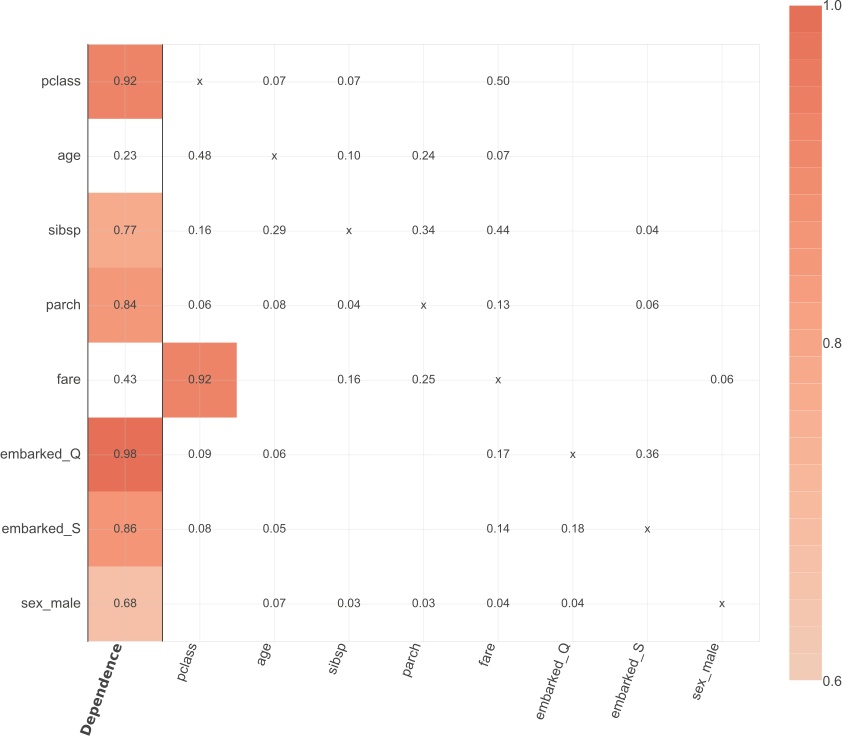

In [24]:
rfpimp.plot_dependence_heatmap(
    rfpimp.feature_dependence_matrix(X_train),
    value_fontsize=12,
    label_fontsize=14,
    figsize=(12, 12)
)

from the image above it looks like pclass (on the x-axis) predicts fare pretty strongly, so lets take fare out and and model again.

In [25]:
cols_to_remove = ['pclass']

rf3 = RandomForestClassifier(random_state=42)

rf3.fit(
    X_train[ 
            [
        col for col in X_train.columns if col not in cols_to_remove
            ]
           ],
    y_train
)

rf3.score(
    X_test[ 
            [
        col for col in X_train.columns if col not in cols_to_remove
            ]
           ],
    y_test
)

0.8015267175572519

In [26]:
# Compare the above to this

rf_4 = RandomForestClassifier(random_state=42)

rf_4.fit(X_train, y_train)

rf_4.score(X_test, y_test)

0.7964376590330788

## Lasso Regression

If you use lasso regression, you can set an alpha parameter that acts as a
regularization parameter. As you increase the value, it gives less weight to
features that are less important.

c:\Users\INNO\Documents\Python Development\ML-Pocket-Reference\.ml_pocket_ref\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Text(0.5, 1.0, 'Regression Coefficients Progression for Lasso Paths')

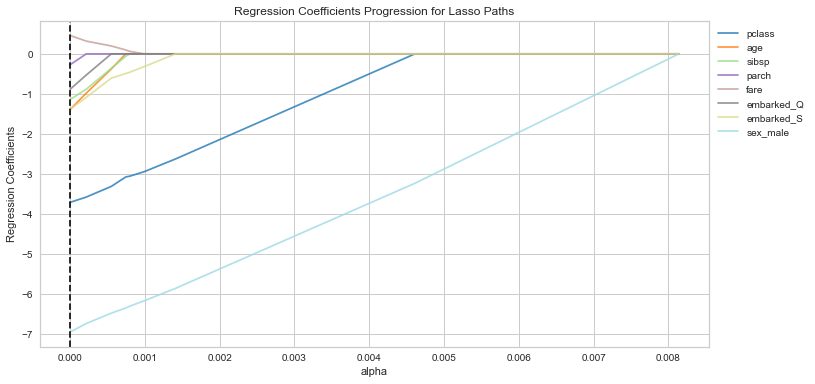

In [27]:
model = linear_model.LassoLarsCV(cv=10, max_n_alphas=1000).fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(12, 6))

cm = iter(
    plt.get_cmap('tab20')(np.linspace(0, 1, X.shape[1]))
)

for i in range(X.shape[1]):
    c = next(cm)
    ax.plot(
        model.alphas_,
        model.coef_path_.T[:, i],
        c=c,
        alpha=0.8,
        label=X.columns[i]
    )
    
ax.axvline(
    model.alpha_,
    linestyle='--',
    c='k',
    label='alphaCV'
)

plt.ylabel('Regression Coefficients')

ax.legend(X.columns, bbox_to_anchor=(1,1))

plt.xlabel('alpha')

plt.title('Regression Coefficients Progression for Lasso Paths')

## Recursive Feature Elimination

Recursive feature elimination will remove the weakest features, then fit a
model (see Figure 8-3). It does this by passing in a scikit-learn model with a
`.coef_` or `.feature_importances_` attribute:

array([1, 1, 1, 1, 1, 1, 1, 1])

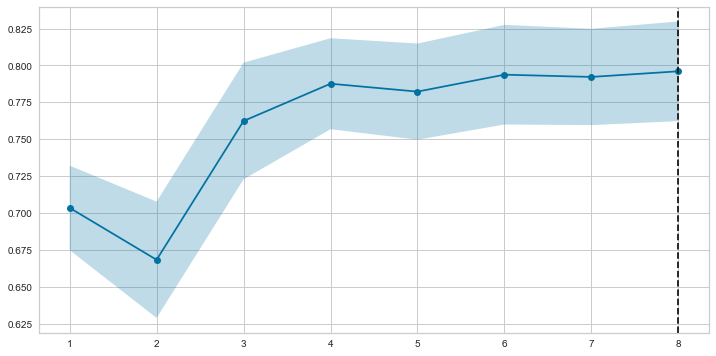

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))

rfe = RFECV(
    RandomForestClassifier(n_estimators=100),
    cv = 10
)

rfe.fit(X,y)

rfe.rfe_estimator_.ranking_

In [29]:
rfe.rfe_estimator_.n_features_

8

In [30]:
mask = rfe.rfe_estimator_.support_

X.columns[mask]

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'embarked_Q', 'embarked_S',
       'sex_male'],
      dtype='object')

> We will use recursive feature elimination to find the 4 most important
features. (In this aggregated dataset we find that we have leaked the
survival column!)

In [31]:
model = RandomForestClassifier(n_estimators=100)

rfe = RFE(model, n_features_to_select=4)

rfe.fit(X, y)

X.columns[rfe.support_]

Index(['pclass', 'age', 'fare', 'sex_male'], dtype='object')

## Mutual Information

Sklearn provides nonparametric tests that will use k-nearest neighbor to
determine the mutual information between features and the target. Mutual
information quantifies the amount of information gained by observing
another variable. The value is zero or more. If the value is zero, then there
is no relation between them (see Figure 8-4). This number is not bounded
and represents the number of bits shared between the feature and the target:

<AxesSubplot:ylabel='feature'>

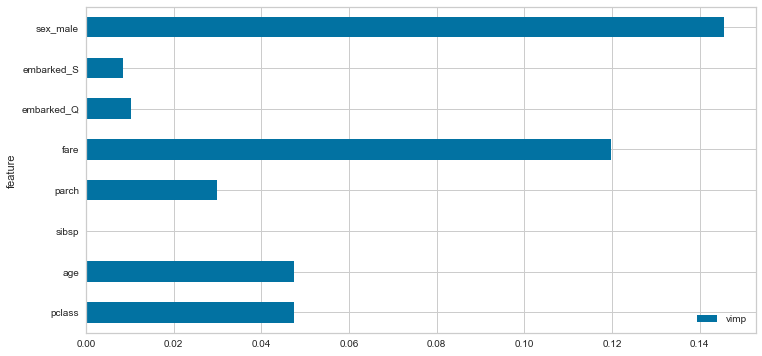

In [32]:
mic = feature_selection.mutual_info_classif(X, y)

fig, ax = plt.subplots(figsize=(12, 6))

(
    pd.DataFrame({
        'feature': X.columns,
        'vimp': mic
                 }
    )
    .set_index('feature')
    .plot.barh(ax=ax)
)

## Principal Component Analysis

Another option for feature selection is to run principal component analysis.
Once you have the main principal components, examine the features that
contribute to them the most. These are features that have more variance.
Note that this is an unsupervised algorithm and doesn’t take y into account.

Before performing Feature selection, please SPLIT THE DATA first.

## Imbalanced Classes

When classifying data, and the classes are not relatively balanced in size, the bias toward more popular classes can carry over into your model. Some ways to deal with Imbalanced Classes are:
- Tree-based Algorithms and Ensembles
- Penalize models
- Upsampling the minority 
- Generate Minority Data
- Downsampling Majority



### Upsampling Minority

> You can upsample the minority class in a couple of ways.

In [34]:
mask = titanic_df['survived'] == 1

surv_df = titanic_df[mask]

death_df = titanic_df[~mask]

# Create a new df the length of the death_df from the surv_df with replacement 
df_upsample = resample(
    surv_df,
    replace=True,
    n_samples=len(death_df),
    random_state=42
)

In [35]:
df_upsample.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
152,1,1,"Hawksford, Mr. Walter James",male,NaN,0,0,16988,30.0000,D45,S,3,NaN,"Kingston, Surrey"
1033,3,1,"Moss, Mr. Albert Johan",male,NaN,0,0,312991,7.7750,NaN,S,B,NaN,NaN
719,3,1,"Cohen, Mr. Gurshon ""Gus""",male,18.0,0,0,A/5 3540,8.0500,NaN,S,12,NaN,"London Brooklyn, NY"
502,2,1,"Mellinger, Mrs. (Elizabeth Anne Maidment)",female,41.0,0,1,250644,19.5000,NaN,S,14,NaN,"England / Bennington, VT"
160,1,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",female,44.0,0,1,111361,57.9792,B18,C,4,NaN,"Chicago, IL"


In [37]:
# Combine the upsampled df to the death_df
df_2 = pd.concat([death_df, df_upsample])

# Now we have balanced classes
df_2['survived'].value_counts()

0    809
1    809
Name: survived, dtype: int64

### Generate Minority Data

The imbalanced-learn library can also generate new samples of minority classes with both the Synthetic Minority Over-sampling Technique (SMOTE) and Adaptive Synthetic (ADASYN) sampling approach algorithms. SMOTE works by choosing one of its k-nearest neighbors connecting a line to one of them, and choosing a point along that line.

`ADASYN` is similar to `SMOTE`, but generates more samples from those that are harder to learn. The classes in imbanced-learn are named `over_sampling.SMOTE` and `over_sampling.ADASYN`.

### Downsampling Majority

> Here we downsample the majority classes.

In [38]:
mask = titanic_df['survived'] == 1

surv_df = titanic_df[mask]

death_df = titanic_df[~mask]

df_downsample = resample(
    death_df,
    replace=False,
    n_samples=len(surv_df),
    random_state=42
)

df_3 = pd.concat([surv_df, df_downsample])




In [39]:
# Preview teh data
df_3.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"


In [40]:
df_3['survived'].value_counts()

1    500
0    500
Name: survived, dtype: int64